In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import tensorflow as tf
import os, sys, time
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import utils, optimization, metrics, plot
import pickle

# Parameters

In [3]:
spix = 256
path = '../data/size{}_splits1000_n500x3/'.format(spix)
input_pattern = 'Box_70*snapshot_050'
file_ext = '.dat'
k = 10

# Data handling

Load the data

In [4]:
queue = []
for file in os.listdir(path):
    if file.endswith(file_ext) and (np.all([x in file for x in input_pattern.split("*")])):
        queue.append(os.path.join(path, file))
nsamples = len(queue)
print('They are {} "{}" files.'.format(nsamples, file_ext))      

They are 15000 ".dat" files.


In [5]:
nsamples = 5000
input_img = np.vstack(map(lambda i:np.fromfile(queue[i], dtype=float32), range(nsamples)))
input_img.resize([nsamples,spix,spix])

In [6]:
input_img = utils.forward_map(input_img,k)

# input_img = np.log(input_img+0.001)

# p = np.random.permutation(nsamples)
# input_img = input_img[p,]

Let us plot 16 images

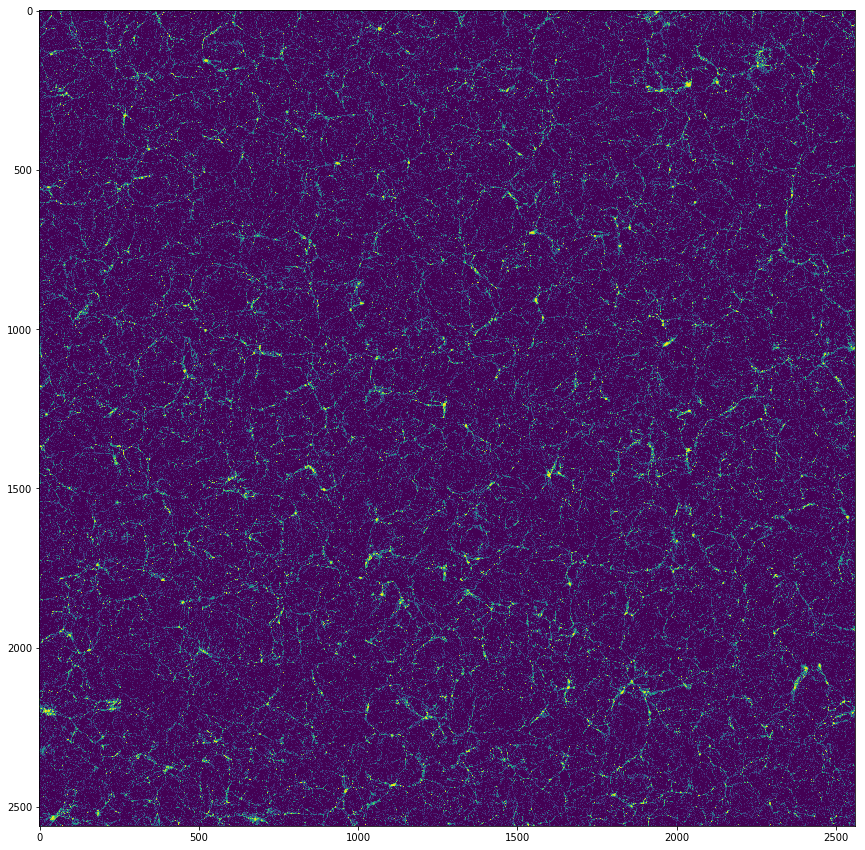

In [7]:
plt.figure(figsize=(15,15))
utils.draw_images(input_img,nx=10,ny=10,px=spix,py=spix)

Let us make small patches of 64 :-)

In [8]:
ns = 64
cut = spix//ns
img_small = np.zeros([nsamples*cut*cut, ns, ns])
for i in range(cut):
    for j in range(cut):
        k = j + i*cut 
        img_small[k*nsamples:(k+1)*nsamples,:,:] = input_img[:,i*ns:(i+1)*ns,j*ns:(j+1)*ns]


# # Reduce the size
# ns = 64
# cut = spix//ns
# img_small = input_img[:,:ns,:ns].copy()
# del input_img

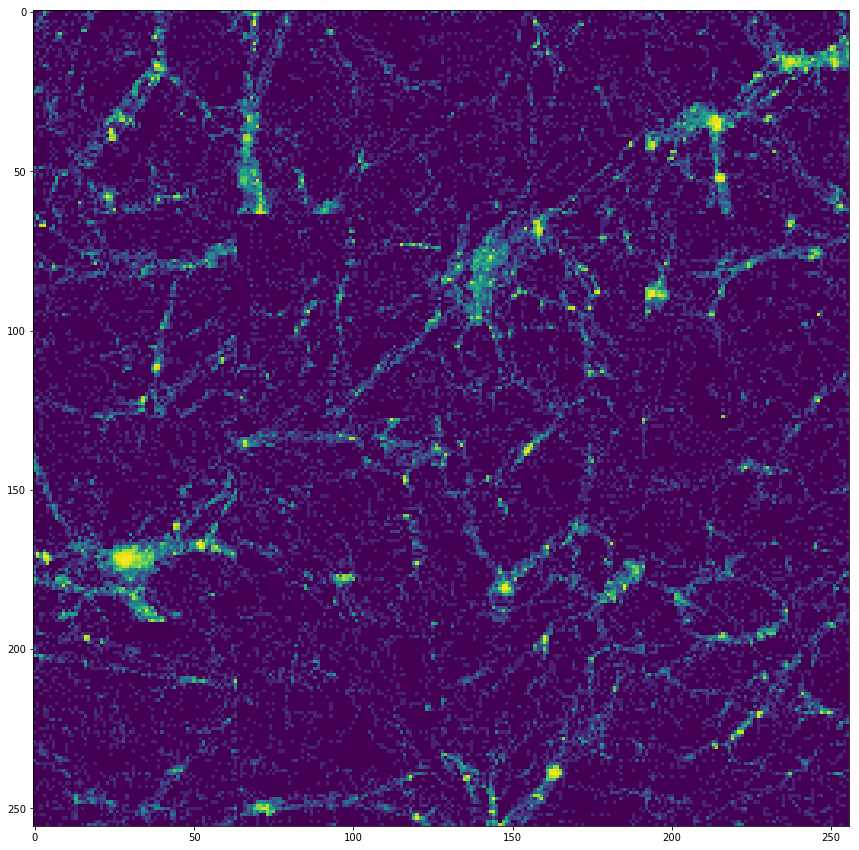

In [9]:
plt.figure(figsize=(15,15))
utils.draw_images(img_small,nx=4,ny=4,px=ns,py=ns)

# A) Train a small GAN

In [10]:
def current_time_str():
    import time, datetime
    d = datetime.datetime.fromtimestamp(time.time())
    return str(d.year)+ '_' + str(d.month)+ '_' + str(d.day)+ '_' + str(d.hour)+ '_' + str(d.minute)

time_str = current_time_str() 

In [11]:
params_discriminator = dict()
params_discriminator['stride'] = [2, 2, 2]
params_discriminator['nfilter'] = [8, 64, 64]
params_discriminator['shape'] = [[5, 5],[5, 5], [3, 3]]
params_discriminator['batch_norm'] = [True, True, True]
params_discriminator['full'] = [128]
params_discriminator['summary'] = True

params_generator = dict()
params_generator['stride'] = [2, 2, 2, 1]
params_generator['latent_dim'] = 100
params_generator['nfilter'] = [64, 64, 32, 1]
params_generator['shape'] = [[3, 3],[5, 5], [5, 5], [5, 5]]
params_generator['batch_norm'] = [True, True, True]
params_generator['full'] = [8*8*64]
params_generator['summary'] = True
params_generator['non_lin'] = 'tanh'

params_optimization = dict()
params_optimization['gamma_gp'] = 10
params_optimization['batch_size'] = 16
params_optimization['optimizer'] = 'adam' # rmsprop / adam
params_optimization['disc_learning_rate'] = 1e-5
params_optimization['gen_learning_rate'] = 1e-5
params_optimization['beta1'] = 0.99
params_optimization['beta2'] = 0.999
params_optimization['epsilon'] = 1e-8
params_optimization['epoch'] = 50

params = dict()
params['generator'] = params_generator
params['discriminator'] = params_discriminator
params['optimization'] = params_optimization

params['image_size'] = [ns, ns]
params['sum_every'] = 200
params['viz_every'] = 200
params['save_every'] = 2000
global_path = '../../saved_result/GAN/'+ time_str +'_size_{}/'.format(ns)
params['summary_dir'] = global_path + 'summary/'
params['save_dir'] = global_path + 'checkpoints/'

params['clip_max_real'] = False
params['log_clip'] = 0.1
params['sigma_smooth'] = 1
params['k'] = k





In [ ]:
from model import generator, discriminator, gan_model
from gan import WGAN

# class gan_model(object):
#     def __init__(self, name='wgan'):
#         self.name = name
#     def generator(self, z, reuse):
#         return generator(z, self.params['generator'], reuse=reuse)
#     def discriminator(self, X, reuse):
#         return discriminator(X, self.params['discriminator'], reuse=reuse)
#     def __call__(self, params, z, X):
#         self.params = params
#         G_fake = self.generator(z, reuse=False)
#         D_real = self.discriminator(X, reuse=False)
#         D_fake = self.discriminator(G_fake, reuse=True)       
    
#         return G_fake, D_real, D_fake

wgan_model = gan_model()
wgan_obj = WGAN(params, wgan_model)

Generator 
------------------------------------------------------------
     The input is of size (?, 100)
     0 Full layer with 4096 outputs
         Size of the variables: (?, 4096)
     Reshape to (?, 8, 8, 64)
     1 Deconv layer with 64 channels
         Batch norm
         Size of the variables: (?, 16, 16, 64)
     2 Deconv layer with 64 channels
         Batch norm
         Size of the variables: (?, 32, 32, 64)
     3 Deconv layer with 32 channels
         Batch norm
         Size of the variables: (?, 64, 64, 32)
     4 Deconv layer with 1 channels
         Size of the variables: (?, 64, 64, 1)
    Non lienarity: tanh
     The output is of size (?, 64, 64, 1)
------------------------------------------------------------

Discriminator 
------------------------------------------------------------
     The input is of size (?, 64, 64, 1)
     0 Conv layer with 8 channels
         Batch norm
         Size of the variables: (?, 32, 32, 8)
     1 Conv layer with 64 channels
      

In [ ]:
wgan_obj.train(img_small)

Epoch: [ 0] [  99/5000] Counter:100	( 3.4 min	7.88 examples/sec	2.032 sec/batch)	L_Disc:29.39120674	L_Gen:0.03593152
Epoch: [ 0] [ 199/5000] Counter:200	( 6.7 min	8.11 examples/sec	1.974 sec/batch)	L_Disc:3.88135099	L_Gen:0.89462519
 [*] [Fake, Real] Min [14.321, 0.178],	Median [88.585,1.166],	Mean [1.093E+02,3.937E+00],	 Max [1.954E+03,3.472E+02],	 Var [1.013E+04,3.808E+02]
 [*] [Comp, Fake, Real] PeakDistance:[1.396, 0.408, 0.146]	CrossPS:[3.960, 8.512, 6.554]	PSD_Diff:329687.284
 [*] New PSD Low achieved 329687.284192 (was 10000000000.000000)
Epoch: [ 0] [ 299/5000] Counter:300	(10.2 min	7.59 examples/sec	2.107 sec/batch)	L_Disc:1.02594399	L_Gen:1.36483741
Epoch: [ 0] [ 399/5000] Counter:400	(13.6 min	7.91 examples/sec	2.022 sec/batch)	L_Disc:1.96915019	L_Gen:2.11274505
 [*] [Fake, Real] Min [13.795, 0.181],	Median [69.317,1.142],	Mean [9.511E+01,2.880E+00],	 Max [2.155E+03,1.950E+02],	 Var [1.245E+04,1.225E+02]
 [*] [Comp, Fake, Real] PeakDistance:[1.777, 0.518, 0.152]	CrossPS:[-6.

Epoch: [ 0] [3299/5000] Counter:3300	(112.1 min	7.78 examples/sec	2.057 sec/batch)	L_Disc:-1.10742998	L_Gen:3.82244039
Epoch: [ 0] [3399/5000] Counter:3400	(115.4 min	8.14 examples/sec	1.966 sec/batch)	L_Disc:-1.42626679	L_Gen:4.45474243
 [*] [Fake, Real] Min [0.275, 0.167],	Median [6.111,1.066],	Mean [2.436E+01,2.068E+00],	 Max [3.222E+03,7.932E+01],	 Var [3.890E+04,2.187E+01]
 [*] [Comp, Fake, Real] PeakDistance:[1.030, 0.638, 0.192]	CrossPS:[-8.296, 42.823, -5.812]	PSD_Diff:185438.928
Epoch: [ 0] [3499/5000] Counter:3500	(118.9 min	7.67 examples/sec	2.087 sec/batch)	L_Disc:-2.09482455	L_Gen:3.09838581
Epoch: [ 0] [3599/5000] Counter:3600	(122.2 min	8.07 examples/sec	1.983 sec/batch)	L_Disc:-0.66192210	L_Gen:2.07601690
 [*] [Fake, Real] Min [0.106, 0.160],	Median [0.607,0.927],	Mean [1.309E+00,1.958E+00],	 Max [4.311E+01,1.021E+02],	 Var [7.926E+00,4.318E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.830, 0.482, 0.334]	CrossPS:[-0.332, 16.837, 4.709]	PSD_Diff:2838.918
Epoch: [ 0] [3699

Epoch: [ 1] [1699/5000] Counter:6700	(227.1 min	7.81 examples/sec	2.049 sec/batch)	L_Disc:-1.06437480	L_Gen:-0.70824134
Epoch: [ 1] [1799/5000] Counter:6800	(230.4 min	8.12 examples/sec	1.970 sec/batch)	L_Disc:-0.86784756	L_Gen:4.44090462
 [*] [Fake, Real] Min [0.101, 0.179],	Median [0.414,0.991],	Mean [1.141E+00,2.780E+00],	 Max [8.058E+01,4.079E+02],	 Var [1.589E+01,6.569E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.211, 0.236, 0.178]	CrossPS:[2.388, -20.278, -16.585]	PSD_Diff:134317.259
Epoch: [ 1] [1899/5000] Counter:6900	(233.9 min	7.71 examples/sec	2.075 sec/batch)	L_Disc:-1.03296328	L_Gen:9.80661583
Epoch: [ 1] [1999/5000] Counter:7000	(237.2 min	8.09 examples/sec	1.977 sec/batch)	L_Disc:-0.73622090	L_Gen:8.64955521
 [*] [Fake, Real] Min [0.101, 0.181],	Median [0.825,1.095],	Mean [3.668E+00,2.581E+00],	 Max [2.710E+02,1.565E+02],	 Var [2.369E+02,5.152E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.267, 0.051, 0.130]	CrossPS:[-14.592, -1.656, 8.286]	PSD_Diff:55909.992
Epoch: [ 1] [

 [*] New PSD Low achieved 0.483969 (was 5.460011)
Epoch: [ 2] [  99/5000] Counter:10100	(342.6 min	7.65 examples/sec	2.092 sec/batch)	L_Disc:-1.42599249	L_Gen:10.42011261
Epoch: [ 2] [ 199/5000] Counter:10200	(345.9 min	8.05 examples/sec	1.987 sec/batch)	L_Disc:-1.11530769	L_Gen:8.66215801
 [*] [Fake, Real] Min [0.111, 0.178],	Median [1.402,1.166],	Mean [5.284E+00,3.937E+00],	 Max [3.972E+02,3.472E+02],	 Var [6.019E+02,3.808E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.150, 0.125, 0.146]	CrossPS:[-10.480, -26.993, 6.554]	PSD_Diff:13905.294
Epoch: [ 2] [ 299/5000] Counter:10300	(349.4 min	7.64 examples/sec	2.095 sec/batch)	L_Disc:-1.25237370	L_Gen:1.13377595
Epoch: [ 2] [ 399/5000] Counter:10400	(352.7 min	8.04 examples/sec	1.991 sec/batch)	L_Disc:-0.71709383	L_Gen:2.03783751
 [*] [Fake, Real] Min [0.107, 0.181],	Median [0.980,1.142],	Mean [3.861E+00,2.880E+00],	 Max [3.265E+02,1.950E+02],	 Var [3.121E+02,1.225E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.241, 0.104, 0.152]	CrossPS:[-14

 [*] [Fake, Real] Min [0.105, 0.167],	Median [0.562,1.066],	Mean [2.679E+00,2.068E+00],	 Max [6.690E+02,7.932E+01],	 Var [1.296E+03,2.187E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.332, 0.347, 0.192]	CrossPS:[3.748, -23.467, -5.812]	PSD_Diff:1124283.706
Epoch: [ 2] [3499/5000] Counter:13500	(458.5 min	7.68 examples/sec	2.084 sec/batch)	L_Disc:-1.75225949	L_Gen:7.97943926
Epoch: [ 2] [3599/5000] Counter:13600	(461.8 min	7.96 examples/sec	2.010 sec/batch)	L_Disc:-1.09632111	L_Gen:9.75093555
 [*] [Fake, Real] Min [0.108, 0.160],	Median [0.630,0.927],	Mean [1.962E+00,1.958E+00],	 Max [1.807E+02,1.021E+02],	 Var [6.165E+01,4.318E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.357, 0.161, 0.334]	CrossPS:[-2.893, 8.528, 4.709]	PSD_Diff:15865.214
Epoch: [ 2] [3699/5000] Counter:13700	(465.3 min	7.69 examples/sec	2.079 sec/batch)	L_Disc:-1.37909138	L_Gen:9.35227776
Epoch: [ 2] [3799/5000] Counter:13800	(468.6 min	8.01 examples/sec	1.998 sec/batch)	L_Disc:-0.82480407	L_Gen:5.45324612
 [*] [Fake, 

Epoch: [ 3] [1799/5000] Counter:16800	(570.5 min	8.04 examples/sec	1.990 sec/batch)	L_Disc:-0.92985737	L_Gen:11.23471260
 [*] [Fake, Real] Min [0.109, 0.179],	Median [0.681,0.991],	Mean [1.556E+00,2.780E+00],	 Max [8.932E+01,4.079E+02],	 Var [1.813E+01,6.569E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.184, 0.096, 0.178]	CrossPS:[-4.877, -13.844, -16.585]	PSD_Diff:189241.464
Epoch: [ 3] [1899/5000] Counter:16900	(573.9 min	7.76 examples/sec	2.062 sec/batch)	L_Disc:-0.40784529	L_Gen:8.36357307
Epoch: [ 3] [1999/5000] Counter:17000	(577.2 min	8.04 examples/sec	1.989 sec/batch)	L_Disc:-1.26318204	L_Gen:0.44536576
 [*] [Fake, Real] Min [0.117, 0.181],	Median [2.197,1.095],	Mean [7.085E+00,2.581E+00],	 Max [3.651E+02,1.565E+02],	 Var [3.411E+02,5.152E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.112, 0.088, 0.130]	CrossPS:[-9.948, -6.124, 8.286]	PSD_Diff:2361.891
Epoch: [ 3] [2099/5000] Counter:17100	(580.7 min	7.69 examples/sec	2.081 sec/batch)	L_Disc:-0.37859458	L_Gen:-1.51671004
Epoch: [ 

Epoch: [ 4] [  99/5000] Counter:20100	(682.5 min	7.70 examples/sec	2.077 sec/batch)	L_Disc:-1.13791978	L_Gen:-0.29334790
Epoch: [ 4] [ 199/5000] Counter:20200	(685.8 min	7.96 examples/sec	2.011 sec/batch)	L_Disc:-0.21837506	L_Gen:-4.69300556
 [*] [Fake, Real] Min [0.114, 0.178],	Median [1.185,1.166],	Mean [3.794E+00,3.937E+00],	 Max [2.166E+02,3.472E+02],	 Var [1.352E+02,3.808E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.314, 0.188, 0.146]	CrossPS:[19.530, 21.161, 6.554]	PSD_Diff:90044.529
Epoch: [ 4] [ 299/5000] Counter:20300	(689.3 min	7.71 examples/sec	2.075 sec/batch)	L_Disc:-0.74191350	L_Gen:1.60704386
Epoch: [ 4] [ 399/5000] Counter:20400	(692.6 min	8.04 examples/sec	1.990 sec/batch)	L_Disc:-1.40486288	L_Gen:8.53610516
 [*] [Fake, Real] Min [0.105, 0.181],	Median [0.485,1.142],	Mean [1.088E+00,2.880E+00],	 Max [5.689E+01,1.950E+02],	 Var [6.341E+00,1.225E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.342, 0.235, 0.152]	CrossPS:[-9.302, 6.911, 0.938]	PSD_Diff:34731.235
Epoch: [ 4] [

Epoch: [ 4] [3499/5000] Counter:23500	(797.9 min	7.77 examples/sec	2.060 sec/batch)	L_Disc:-0.54942018	L_Gen:0.71586907
Epoch: [ 4] [3599/5000] Counter:23600	(801.1 min	8.13 examples/sec	1.967 sec/batch)	L_Disc:-0.53531116	L_Gen:-3.10619140
 [*] [Fake, Real] Min [0.111, 0.160],	Median [1.087,0.927],	Mean [3.409E+00,1.958E+00],	 Max [2.017E+02,1.021E+02],	 Var [1.166E+02,4.318E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.731, 0.156, 0.334]	CrossPS:[1.429, -11.901, 4.709]	PSD_Diff:265.982
Epoch: [ 4] [3699/5000] Counter:23700	(804.6 min	7.70 examples/sec	2.078 sec/batch)	L_Disc:-0.52305478	L_Gen:1.23553801
Epoch: [ 4] [3799/5000] Counter:23800	(807.9 min	8.08 examples/sec	1.979 sec/batch)	L_Disc:-1.22932613	L_Gen:7.36970997
 [*] [Fake, Real] Min [0.108, 0.170],	Median [0.478,1.042],	Mean [1.567E+00,2.287E+00],	 Max [1.001E+02,1.441E+02],	 Var [2.744E+01,5.563E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.208, 0.288, 0.127]	CrossPS:[-3.961, 9.153, -13.140]	PSD_Diff:14901.361
Epoch: [ 4] [3

Epoch: [ 5] [1899/5000] Counter:26900	(912.1 min	7.75 examples/sec	2.065 sec/batch)	L_Disc:-0.48344177	L_Gen:-2.35024691
Epoch: [ 5] [1999/5000] Counter:27000	(915.3 min	8.15 examples/sec	1.963 sec/batch)	L_Disc:-0.44898602	L_Gen:-0.74541068
 [*] [Fake, Real] Min [0.106, 0.181],	Median [0.538,1.095],	Mean [1.469E+00,2.581E+00],	 Max [1.651E+02,1.565E+02],	 Var [7.433E+01,5.152E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.177, 0.124, 0.130]	CrossPS:[2.552, -7.448, 8.286]	PSD_Diff:102995.432
Epoch: [ 5] [2099/5000] Counter:27100	(918.8 min	7.76 examples/sec	2.062 sec/batch)	L_Disc:-1.03328335	L_Gen:4.09457016
Epoch: [ 5] [2199/5000] Counter:27200	(922.1 min	8.09 examples/sec	1.978 sec/batch)	L_Disc:-0.66109765	L_Gen:4.66085768
 [*] [Fake, Real] Min [0.108, 0.190],	Median [0.662,1.201],	Mean [2.387E+00,3.069E+00],	 Max [1.214E+02,1.782E+02],	 Var [5.601E+01,9.597E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.505, 0.266, 0.089]	CrossPS:[-1.333, 15.480, -2.130]	PSD_Diff:31.844
Epoch: [ 5] [2

Epoch: [ 6] [ 299/5000] Counter:30300	(1024.8 min	10.19 examples/sec	1.571 sec/batch)	L_Disc:-0.90472478	L_Gen:1.15888929
Epoch: [ 6] [ 399/5000] Counter:30400	(1027.3 min	10.70 examples/sec	1.495 sec/batch)	L_Disc:-0.40121400	L_Gen:-2.92637110
 [*] [Fake, Real] Min [0.133, 0.181],	Median [1.424,1.142],	Mean [3.828E+00,2.880E+00],	 Max [1.833E+02,1.950E+02],	 Var [1.524E+02,1.225E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.182, 0.178, 0.152]	CrossPS:[-1.738, -10.151, 0.938]	PSD_Diff:1462.621
Epoch: [ 6] [ 499/5000] Counter:30500	(1029.9 min	10.13 examples/sec	1.579 sec/batch)	L_Disc:-0.12272688	L_Gen:-0.33873579
Epoch: [ 6] [ 599/5000] Counter:30600	(1032.4 min	10.59 examples/sec	1.511 sec/batch)	L_Disc:-1.10726690	L_Gen:6.35395813
 [*] [Fake, Real] Min [0.112, 0.158],	Median [0.491,1.077],	Mean [9.156E-01,2.607E+00],	 Max [2.253E+01,2.089E+02],	 Var [2.854E+00,1.470E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.152, 0.109, 0.161]	CrossPS:[1.079, -0.533, -6.994]	PSD_Diff:96681.832
Epoc

 [*] [Fake, Real] Min [0.107, 0.160],	Median [0.778,0.927],	Mean [1.879E+00,1.958E+00],	 Max [5.535E+01,1.021E+02],	 Var [1.285E+01,4.318E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.645, 0.195, 0.334]	CrossPS:[1.466, -2.213, 4.709]	PSD_Diff:6846.684
Epoch: [ 6] [3699/5000] Counter:33700	(1112.3 min	10.02 examples/sec	1.597 sec/batch)	L_Disc:-0.41605747	L_Gen:5.36922359
Epoch: [ 6] [3799/5000] Counter:33800	(1114.8 min	10.62 examples/sec	1.507 sec/batch)	L_Disc:-0.70387423	L_Gen:6.62284374
 [*] [Fake, Real] Min [0.143, 0.170],	Median [1.879,1.042],	Mean [6.353E+00,2.287E+00],	 Max [5.538E+02,1.441E+02],	 Var [6.774E+02,5.563E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.231, 0.263, 0.127]	CrossPS:[-11.722, 8.445, -13.140]	PSD_Diff:12755.105
Epoch: [ 6] [3899/5000] Counter:33900	(1117.5 min	9.81 examples/sec	1.632 sec/batch)	L_Disc:-1.07448840	L_Gen:4.36167336
Epoch: [ 6] [3999/5000] Counter:34000	(1120.1 min	10.51 examples/sec	1.523 sec/batch)	L_Disc:-0.40154228	L_Gen:0.89183289
 [*] [F

Epoch: [ 7] [1899/5000] Counter:36900	(1196.0 min	9.99 examples/sec	1.602 sec/batch)	L_Disc:-0.40003282	L_Gen:6.28954124
Epoch: [ 7] [1999/5000] Counter:37000	(1198.5 min	10.52 examples/sec	1.522 sec/batch)	L_Disc:-0.52714962	L_Gen:6.47969627
 [*] [Fake, Real] Min [0.136, 0.181],	Median [1.443,1.095],	Mean [3.876E+00,2.581E+00],	 Max [2.843E+02,1.565E+02],	 Var [1.553E+02,5.152E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.258, 0.083, 0.130]	CrossPS:[-1.449, -16.283, 8.286]	PSD_Diff:9560.016
Epoch: [ 7] [2099/5000] Counter:37100	(1201.2 min	10.12 examples/sec	1.581 sec/batch)	L_Disc:-0.40245584	L_Gen:4.12911034
Epoch: [ 7] [2199/5000] Counter:37200	(1203.7 min	10.55 examples/sec	1.516 sec/batch)	L_Disc:-0.10037372	L_Gen:2.07001352
 [*] [Fake, Real] Min [0.116, 0.190],	Median [0.865,1.201],	Mean [2.159E+00,3.069E+00],	 Max [6.527E+01,1.782E+02],	 Var [2.209E+01,9.597E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.281, 0.134, 0.089]	CrossPS:[5.363, -4.722, -2.130]	PSD_Diff:32635.598
Epoch: 

 [*] [Fake, Real] Min [0.123, 0.178],	Median [1.623,1.166],	Mean [4.362E+00,3.937E+00],	 Max [1.458E+02,3.472E+02],	 Var [1.048E+02,3.808E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.339, 0.067, 0.146]	CrossPS:[-5.363, -3.638, 6.554]	PSD_Diff:152348.878
Epoch: [ 8] [ 299/5000] Counter:40300	(1284.7 min	9.92 examples/sec	1.613 sec/batch)	L_Disc:-0.27889663	L_Gen:-2.83382607
Epoch: [ 8] [ 399/5000] Counter:40400	(1287.2 min	10.49 examples/sec	1.525 sec/batch)	L_Disc:-0.13237815	L_Gen:-2.05212736
 [*] [Fake, Real] Min [0.116, 0.181],	Median [0.764,1.142],	Mean [1.675E+00,2.880E+00],	 Max [7.276E+01,1.950E+02],	 Var [1.609E+01,1.225E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.473, 0.245, 0.152]	CrossPS:[-2.410, -0.764, 0.938]	PSD_Diff:25500.106
Epoch: [ 8] [ 499/5000] Counter:40500	(1289.9 min	9.94 examples/sec	1.609 sec/batch)	L_Disc:-0.62127525	L_Gen:2.68000603
Epoch: [ 8] [ 599/5000] Counter:40600	(1292.4 min	10.50 examples/sec	1.524 sec/batch)	L_Disc:-0.79230332	L_Gen:5.69815922
 [*] 

Epoch: [ 8] [3499/5000] Counter:43500	(1368.2 min	9.98 examples/sec	1.604 sec/batch)	L_Disc:-0.34553921	L_Gen:7.03804731
Epoch: [ 8] [3599/5000] Counter:43600	(1370.7 min	10.51 examples/sec	1.522 sec/batch)	L_Disc:-0.71419322	L_Gen:4.80076075
 [*] [Fake, Real] Min [0.162, 0.160],	Median [2.021,0.927],	Mean [4.161E+00,1.958E+00],	 Max [1.080E+02,1.021E+02],	 Var [5.245E+01,4.318E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.557, 0.261, 0.334]	CrossPS:[9.998, 2.188, 4.709]	PSD_Diff:19880.962
Epoch: [ 8] [3699/5000] Counter:43700	(1373.4 min	9.87 examples/sec	1.621 sec/batch)	L_Disc:-0.73760313	L_Gen:0.77391303
Epoch: [ 8] [3799/5000] Counter:43800	(1376.0 min	10.33 examples/sec	1.549 sec/batch)	L_Disc:-0.23427686	L_Gen:-0.46311003
 [*] [Fake, Real] Min [0.116, 0.170],	Median [0.736,1.042],	Mean [1.773E+00,2.287E+00],	 Max [6.251E+01,1.441E+02],	 Var [2.031E+01,5.563E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.237, 0.153, 0.127]	CrossPS:[1.635, 13.487, -13.140]	PSD_Diff:5016.843
Epoch: [ 

 [*] [Fake, Real] Min [0.126, 0.179],	Median [1.096,0.991],	Mean [2.754E+00,2.780E+00],	 Max [9.528E+01,4.079E+02],	 Var [3.735E+01,6.569E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.156, 0.117, 0.178]	CrossPS:[6.252, 3.034, -16.585]	PSD_Diff:244581.249
Epoch: [ 9] [1899/5000] Counter:46900	(1456.9 min	10.11 examples/sec	1.582 sec/batch)	L_Disc:-0.28047952	L_Gen:1.29329610
Epoch: [ 9] [1999/5000] Counter:47000	(1459.4 min	10.53 examples/sec	1.519 sec/batch)	L_Disc:-0.62475318	L_Gen:2.55802250
 [*] [Fake, Real] Min [0.109, 0.181],	Median [0.590,1.095],	Mean [1.442E+00,2.581E+00],	 Max [4.887E+01,1.565E+02],	 Var [1.224E+01,5.152E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.221, 0.287, 0.130]	CrossPS:[-1.366, 2.971, 8.286]	PSD_Diff:294.149
Epoch: [ 9] [2099/5000] Counter:47100	(1462.1 min	10.06 examples/sec	1.590 sec/batch)	L_Disc:-0.72006750	L_Gen:4.33190536
Epoch: [ 9] [2199/5000] Counter:47200	(1464.6 min	10.47 examples/sec	1.528 sec/batch)	L_Disc:-0.58802021	L_Gen:3.22584176
 [*] [Fa

Epoch: [10] [  99/5000] Counter:50100	(1540.1 min	9.89 examples/sec	1.617 sec/batch)	L_Disc:-0.31472635	L_Gen:1.17576885
Epoch: [10] [ 199/5000] Counter:50200	(1542.6 min	10.58 examples/sec	1.513 sec/batch)	L_Disc:-0.85221827	L_Gen:3.93443894
 [*] [Fake, Real] Min [0.129, 0.178],	Median [0.662,1.166],	Mean [1.343E+00,3.937E+00],	 Max [4.275E+01,3.472E+02],	 Var [8.623E+00,3.808E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.168, 0.160, 0.146]	CrossPS:[1.465, 2.578, 6.554]	PSD_Diff:207909.894
Epoch: [10] [ 299/5000] Counter:50300	(1545.2 min	10.08 examples/sec	1.588 sec/batch)	L_Disc:-0.38254148	L_Gen:4.72554111
Epoch: [10] [ 399/5000] Counter:50400	(1547.8 min	10.59 examples/sec	1.511 sec/batch)	L_Disc:-0.53053325	L_Gen:2.21349335
 [*] [Fake, Real] Min [0.137, 0.181],	Median [1.567,1.142],	Mean [4.071E+00,2.880E+00],	 Max [1.486E+02,1.950E+02],	 Var [7.564E+01,1.225E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.178, 0.204, 0.152]	CrossPS:[-13.575, -12.775, 0.938]	PSD_Diff:18549.769
Epoch:

 [*] [Fake, Real] Min [0.126, 0.167],	Median [0.814,1.066],	Mean [1.611E+00,2.068E+00],	 Max [1.031E+02,7.932E+01],	 Var [2.326E+01,2.187E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.311, 0.149, 0.192]	CrossPS:[0.024, -0.996, -5.812]	PSD_Diff:7355.480
Epoch: [10] [3499/5000] Counter:53500	(1628.5 min	10.09 examples/sec	1.586 sec/batch)	L_Disc:-0.41268590	L_Gen:4.39005232
Epoch: [10] [3599/5000] Counter:53600	(1631.0 min	10.39 examples/sec	1.540 sec/batch)	L_Disc:-0.57672811	L_Gen:3.52350736
 [*] [Fake, Real] Min [0.122, 0.160],	Median [1.336,0.927],	Mean [3.056E+00,1.958E+00],	 Max [8.030E+01,1.021E+02],	 Var [3.504E+01,4.318E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.799, 0.069, 0.334]	CrossPS:[-1.972, -11.062, 4.709]	PSD_Diff:7387.324
Epoch: [10] [3699/5000] Counter:53700	(1633.7 min	10.02 examples/sec	1.596 sec/batch)	L_Disc:-0.50858974	L_Gen:0.62860394
Epoch: [10] [3799/5000] Counter:53800	(1636.2 min	10.58 examples/sec	1.512 sec/batch)	L_Disc:-0.22102025	L_Gen:0.64178008
 [*] [F

Epoch: [11] [1699/5000] Counter:56700	(1711.6 min	10.03 examples/sec	1.595 sec/batch)	L_Disc:-0.34904096	L_Gen:1.58614969
Epoch: [11] [1799/5000] Counter:56800	(1714.2 min	10.49 examples/sec	1.525 sec/batch)	L_Disc:-0.33977386	L_Gen:3.73491049
 [*] [Fake, Real] Min [0.110, 0.179],	Median [0.642,0.991],	Mean [1.384E+00,2.780E+00],	 Max [6.090E+01,4.079E+02],	 Var [1.576E+01,6.569E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.193, 0.203, 0.178]	CrossPS:[-6.178, -0.872, -16.585]	PSD_Diff:216032.564
Epoch: [11] [1899/5000] Counter:56900	(1716.8 min	10.04 examples/sec	1.593 sec/batch)	L_Disc:-0.39381430	L_Gen:3.76672363
Epoch: [11] [1999/5000] Counter:57000	(1719.4 min	10.41 examples/sec	1.538 sec/batch)	L_Disc:-0.70899212	L_Gen:0.85675031
 [*] [Fake, Real] Min [0.128, 0.181],	Median [1.036,1.095],	Mean [2.645E+00,2.581E+00],	 Max [1.085E+02,1.565E+02],	 Var [4.395E+01,5.152E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.125, 0.119, 0.130]	CrossPS:[2.544, 3.257, 8.286]	PSD_Diff:305.052
Epoch: 

 [*] [Fake, Real] Min [0.135, 0.167],	Median [1.180,0.910],	Mean [2.590E+00,1.984E+00],	 Max [5.673E+01,1.411E+02],	 Var [2.162E+01,3.549E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.357, 0.277, 0.246]	CrossPS:[13.518, -6.194, -11.173]	PSD_Diff:10967.653
Epoch: [12] [  99/5000] Counter:60100	(1800.2 min	9.99 examples/sec	1.601 sec/batch)	L_Disc:-0.34524563	L_Gen:-0.49516338
Epoch: [12] [ 199/5000] Counter:60200	(1802.7 min	10.56 examples/sec	1.515 sec/batch)	L_Disc:-0.69054395	L_Gen:1.06924617
 [*] [Fake, Real] Min [0.138, 0.178],	Median [1.057,1.166],	Mean [1.744E+00,3.937E+00],	 Max [3.998E+01,3.472E+02],	 Var [8.944E+00,3.808E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.210, 0.118, 0.146]	CrossPS:[-5.267, 0.192, 6.554]	PSD_Diff:275993.052
Epoch: [12] [ 299/5000] Counter:60300	(1805.4 min	9.99 examples/sec	1.601 sec/batch)	L_Disc:-0.45825920	L_Gen:2.93917418
Epoch: [12] [ 399/5000] Counter:60400	(1807.9 min	10.51 examples/sec	1.523 sec/batch)	L_Disc:-0.35293797	L_Gen:3.04028773
 [*] 

Epoch: [12] [3299/5000] Counter:63300	(1883.6 min	9.88 examples/sec	1.620 sec/batch)	L_Disc:-0.35864747	L_Gen:0.05355802
Epoch: [12] [3399/5000] Counter:63400	(1886.1 min	10.44 examples/sec	1.533 sec/batch)	L_Disc:-0.10211682	L_Gen:0.59210086
 [*] [Fake, Real] Min [0.139, 0.167],	Median [0.823,1.066],	Mean [1.453E+00,2.068E+00],	 Max [3.775E+01,7.932E+01],	 Var [5.654E+00,2.187E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.355, 0.191, 0.192]	CrossPS:[-4.088, 3.797, -5.812]	PSD_Diff:2180.960
Epoch: [12] [3499/5000] Counter:63500	(1888.8 min	10.04 examples/sec	1.594 sec/batch)	L_Disc:-0.76239634	L_Gen:3.76198697
Epoch: [12] [3599/5000] Counter:63600	(1891.3 min	10.52 examples/sec	1.521 sec/batch)	L_Disc:-0.04323339	L_Gen:5.72077560
 [*] [Fake, Real] Min [0.169, 0.160],	Median [1.299,0.927],	Mean [6.099E+00,1.958E+00],	 Max [2.254E+03,1.021E+02],	 Var [1.624E+04,4.318E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.320, 0.285, 0.334]	CrossPS:[7.333, -26.884, 4.709]	PSD_Diff:1583948.391
Epoch:

 [*] [Fake, Real] Min [0.168, 0.184],	Median [1.206,1.185],	Mean [2.082E+00,3.231E+00],	 Max [4.225E+01,2.689E+02],	 Var [9.301E+00,2.508E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.299, 0.196, 0.180]	CrossPS:[3.422, -7.672, -6.742]	PSD_Diff:159233.004
Epoch: [13] [1699/5000] Counter:66700	(1970.4 min	10.08 examples/sec	1.587 sec/batch)	L_Disc:-0.57981092	L_Gen:3.93125296
Epoch: [13] [1799/5000] Counter:66800	(1972.9 min	10.97 examples/sec	1.458 sec/batch)	L_Disc:-0.62756300	L_Gen:2.25146532
 [*] [Fake, Real] Min [0.137, 0.179],	Median [1.185,0.991],	Mean [2.670E+00,2.780E+00],	 Max [1.111E+02,4.079E+02],	 Var [5.888E+01,6.569E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.251, 0.261, 0.178]	CrossPS:[-15.263, -6.806, -16.585]	PSD_Diff:195577.410
Epoch: [13] [1899/5000] Counter:66900	(1975.5 min	10.23 examples/sec	1.565 sec/batch)	L_Disc:-0.28494614	L_Gen:1.78116202
Epoch: [13] [1999/5000] Counter:67000	(1978.0 min	10.56 examples/sec	1.516 sec/batch)	L_Disc:-0.64641225	L_Gen:2.76738548
 

Epoch: [13] [4999/5000] Counter:70000	(2071.6 min	7.99 examples/sec	2.002 sec/batch)	L_Disc:-0.36031041	L_Gen:4.32519627
 [*] [Fake, Real] Min [0.138, 0.167],	Median [1.102,0.910],	Mean [2.982E+00,1.984E+00],	 Max [1.573E+02,1.411E+02],	 Var [1.547E+02,3.549E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.469, 0.291, 0.246]	CrossPS:[13.181, 4.340, -11.173]	PSD_Diff:7908.737
Epoch: [14] [  99/5000] Counter:70100	(2075.1 min	7.59 examples/sec	2.108 sec/batch)	L_Disc:-0.47639596	L_Gen:2.30456448
Epoch: [14] [ 199/5000] Counter:70200	(2078.4 min	8.03 examples/sec	1.993 sec/batch)	L_Disc:-0.12878776	L_Gen:0.89003074
 [*] [Fake, Real] Min [0.167, 0.178],	Median [1.136,1.166],	Mean [2.233E+00,3.937E+00],	 Max [6.337E+01,3.472E+02],	 Var [1.776E+01,3.808E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.180, 0.152, 0.146]	CrossPS:[9.235, -0.389, 6.554]	PSD_Diff:190597.282
Epoch: [14] [ 299/5000] Counter:70300	(2081.9 min	7.58 examples/sec	2.111 sec/batch)	L_Disc:-0.57257062	L_Gen:1.60245669
Epoch: [14

In [ ]:

gen_sample, gen_sample_raw = wgan_obj.generate()
        

/data/.virtualenvs/fma/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/data/.virtualenvs/fma/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/.virtualenvs/fma/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


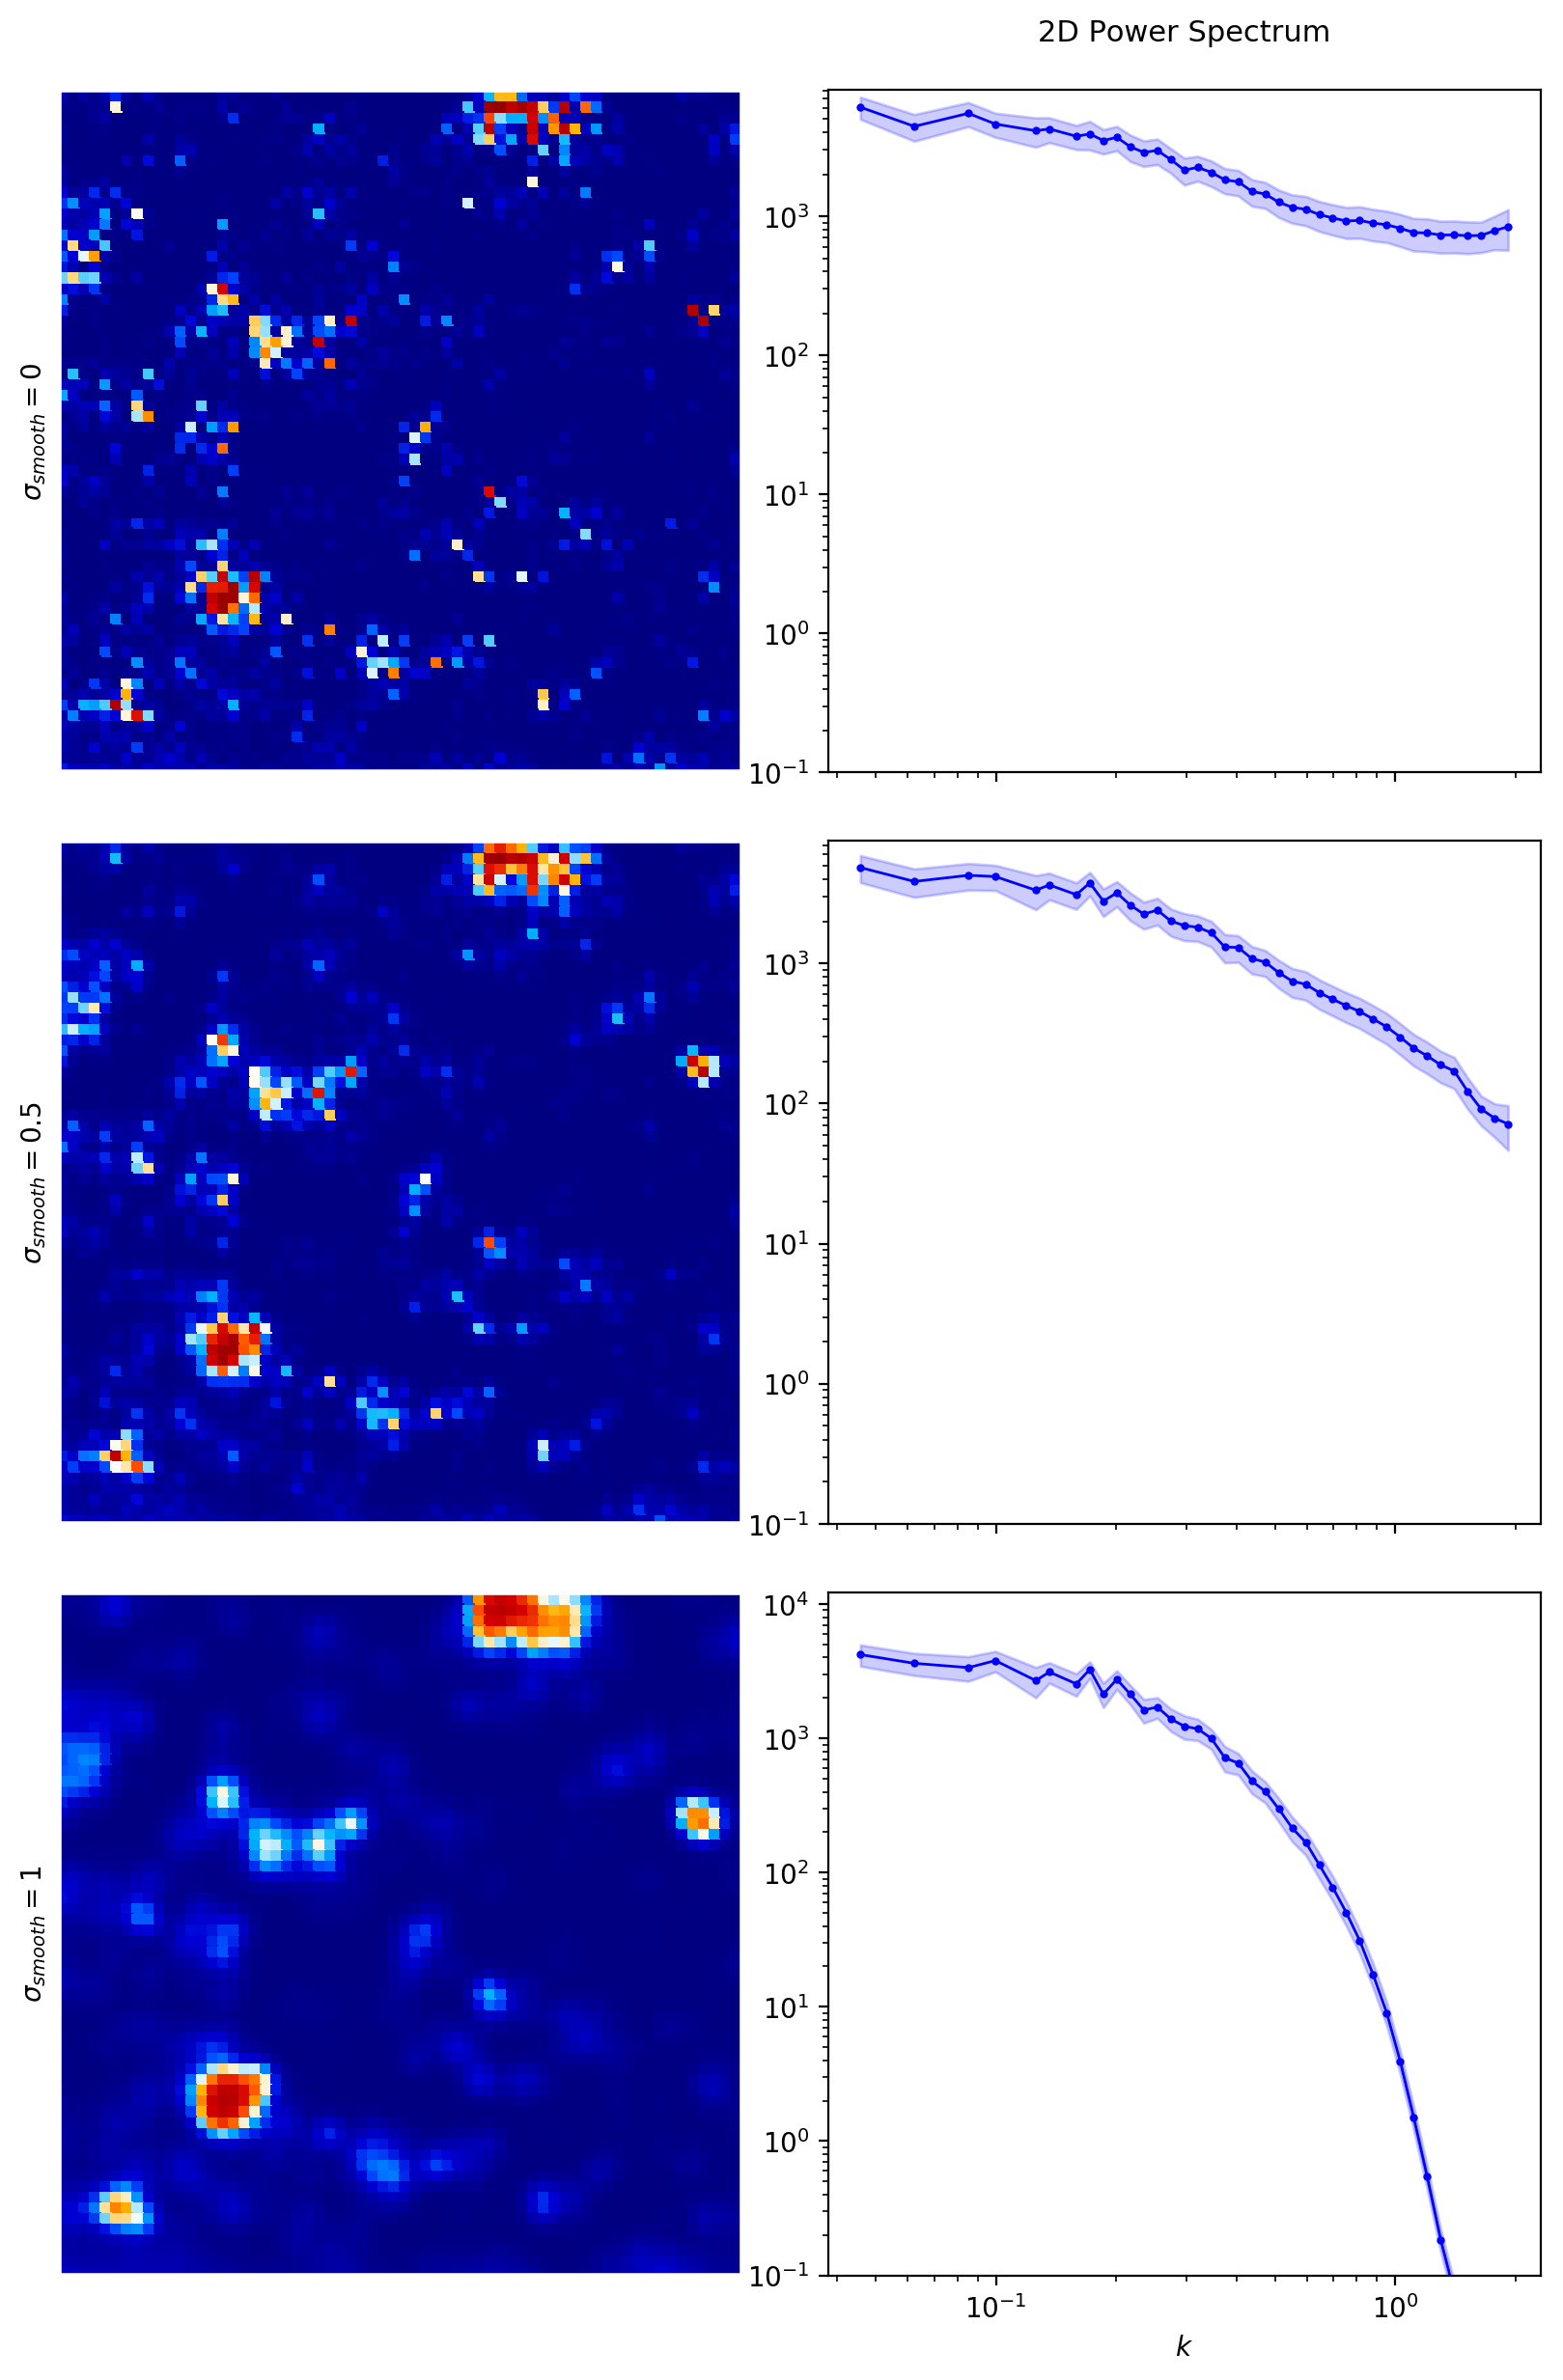

In [18]:
import plot

plot.plot_images_psd(gen_sample_raw,'' , sigma_smooth = [0,0.5,1])
